# NLP with oil and renewable energies project

#### Get libraries

In [14]:
import requests
import re
import json
import sys
import os
import time
import uuid
import warnings
from bs4 import BeautifulSoup
from collections import Counter
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
import numpy as np
from PIL import Image
from pyspark.ml.feature import CountVectorizer
from sklearn.linear_model import LogisticRegression
import argparse
from matplotlib import pyplot as plt
import wordcloud
import requests, json
import pyspark
from pyspark import SparkContext
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
import re
import itertools
import unicodedata
import networkx as nx
from scipy.spatial import distance
%matplotlib inline
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

### Creating dfs

In [15]:
corpus_oil_price=pd.read_csv('data/corpus_oil_price_3.csv', index_col=0)
corpus_alternative_energies=pd.read_csv('data/corpus_alternative_energies_3.csv', index_col=0)
corpus_crude_oil=pd.read_csv('data/corpus_crude_oil_3.csv', index_col=0)
corpus_oil_price

,title,date_published,content,baseline_sentiment,vader_sentiment,most_common_words
0,$70 Oil Won't Keep OPEC Happy,2021-11-29T19:00:00-06:00,One daymdashthat was all it took oil prices to...,-1,0.9448,"['oil', ' ', 'OPEC', '$', 'release', 'new', 'b..."
1,Why This Oil Price Slump May Not Be Bad News F...,2021-12-02T19:00:00-06:00,Crude oil prices are plunging under the weight...,-1,0.9957,"[' ', 'production', 'shale', 'oil', 'prices', ..."
2,The Double Irony Of Biden's Plea To OPEC,2021-11-10T13:00:00-06:00,As I wrote in February of this year innbspThe ...,-1,0.8805,"['oil', ' ', 'Biden', 'prices', 'Administratio..."
3,The Oil Price Rally Is Far From Over,2021-11-09T19:00:00-06:00,How much higher could oil prices go This is th...,1,0.1027,"['oil', ' ', 'prices', 'demand', '$', 'higher'..."
4,"Biden Threatens OPEC With Undisclosed ""Tools""",2021-11-08T10:00:00-06:00,There are other tools in the arsenal that we h...,-1,-0.6269,"[' ', 'OPEC', 'oil', 'pump', 'tools', 'Preside..."
...,...,...,...,...,...,...
2183,A Disobliging Update on the Price of Oil,2010-01-09T16:21:21-06:00,There still seems to be a deplorable uncertain...,-1,0.9947,"['oil', 'price', 'ndash', 'Saudi', 'Watling', ..."
2184,What Happens When the Wells Run Dry,2010-01-08T16:55:39-06:00,One nagging question that the industrial world...,1,-0.7541,"['oil', 'run', 'begin', 'producing', 'day', 't..."
2185,Petro Unfriendly California Changing it's Stan...,2009-12-30T14:18:05-06:00,The financial crisis changed the way people th...,-1,0.0982,"['oil', 'state', 'states', 'drilling', 'financ..."
2186,New Techniques Oil Companies are Using in Dril...,2009-11-25T16:35:34-06:00,As the politics and philosophical arguments ab...,1,0.9985,"['drilling', 'oil', 'wells', 'new', 'rdquo', '..."


In [18]:
corpus_oil_price["date_published"] = pd.to_datetime(corpus_oil_price["date_published"], utc=True)

In [19]:
corpus_oil_price['year'] = corpus_oil_price['date_published'].dt.year

In [20]:
filtered_df = corpus_oil_price.loc[corpus_oil_price['year']==2017]

In [21]:
filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("[","")
filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("]","")
filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("'","")
filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("',","")
filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace(",'","")
filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace(",","")

<ipython-input-21-6984304577fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("[","")
<ipython-input-21-6984304577fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("]","")
<ipython-input-21-6984304577fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [22]:
col_one_list_2 = filtered_df['most_common_words'].tolist()
col_one_list = []
for i in col_one_list_2:
    listRes = list(i.split(" "))
    col_one_list.append(listRes)   
col_one_list

[['U.S.',
  '',
  '',
  'exports',
  'oil',
  'crude',
  'high',
  'Brent',
  'year',
  'discount',
  'WTI',
  'mb',
  'd',
  '$',
  'barrel',
  '2018',
  'barrels',
  'export',
  '7',
  'China',
  'rise',
  '2017'],
 ['oil',
  '',
  '',
  '$',
  'supply',
  'barrel',
  'year',
  '2018',
  'OPEC',
  'analysts',
  'forecast',
  'WTI',
  'Reuters',
  'growth',
  'prices',
  'Thursday',
  'demand',
  'high',
  'commitment',
  'production',
  'cuts',
  '55.78'],
 ['Libya',
  '',
  '',
  'oil',
  'explosion',
  'pipeline',
  'news',
  'Libyan',
  'source',
  'Times',
  'blast',
  '',
  '',
  '',
  '',
  'Waha',
  'attack',
  'Brent',
  'Es',
  'Sider',
  'terminal',
  '30',
  'km',
  'northwest',
  'said'],
 ['year',
  '',
  '',
  'months',
  'U.S.',
  '$',
  'production',
  'couple',
  'WTI',
  'global',
  'oil',
  'output',
  'like',
  'looking',
  '2018',
  'growth',
  'Oil',
  'increase',
  'coming',
  'crude',
  'pressure',
  'drilling'],
 ['',
  '',
  'oil',
  'OPEC',
  'Goldman',
  '

In [23]:
stopwords = ["$","d","oil","prices","price",""," "]
for c in col_one_list:
        #for i in range(len(c)):
        #    c[i] = c[i].lower()
        for word in c:  # iterating on a copy since removing will mess things up
            if word in stopwords:
                c.remove(word)
col_one_list

[['U.S.',
  '',
  'exports',
  'crude',
  'high',
  'Brent',
  'year',
  'discount',
  'WTI',
  'mb',
  '$',
  'barrel',
  '2018',
  'barrels',
  'export',
  '7',
  'China',
  'rise',
  '2017'],
 ['',
  '$',
  'supply',
  'barrel',
  'year',
  '2018',
  'OPEC',
  'analysts',
  'forecast',
  'WTI',
  'Reuters',
  'growth',
  'Thursday',
  'demand',
  'high',
  'commitment',
  'production',
  'cuts',
  '55.78'],
 ['Libya',
  'explosion',
  'pipeline',
  'news',
  'Libyan',
  'source',
  'Times',
  'blast',
  '',
  '',
  '',
  'Waha',
  'attack',
  'Brent',
  'Es',
  'Sider',
  'terminal',
  '30',
  'km',
  'northwest',
  'said'],
 ['year',
  '',
  'months',
  'U.S.',
  'production',
  'couple',
  'WTI',
  'global',
  'output',
  'like',
  'looking',
  '2018',
  'growth',
  'Oil',
  'increase',
  'coming',
  'crude',
  'pressure',
  'drilling'],
 ['',
  'OPEC',
  'Goldman',
  'market',
  '2018',
  'exit',
  'said',
  'Sachs',
  'production',
  'week',
  'inventories',
  'deal',
  'year',


In [24]:
stopwords = ["$","d","oil","prices","price",""," "]
for c in col_one_list:
        #for i in range(len(c)):
        #    c[i] = c[i].lower()
        for word in c:  # iterating on a copy since removing will mess things up
            if word in stopwords:
                c.remove(word)
col_one_list

[['U.S.',
  'exports',
  'crude',
  'high',
  'Brent',
  'year',
  'discount',
  'WTI',
  'mb',
  'barrel',
  '2018',
  'barrels',
  'export',
  '7',
  'China',
  'rise',
  '2017'],
 ['$',
  'supply',
  'barrel',
  'year',
  '2018',
  'OPEC',
  'analysts',
  'forecast',
  'WTI',
  'Reuters',
  'growth',
  'Thursday',
  'demand',
  'high',
  'commitment',
  'production',
  'cuts',
  '55.78'],
 ['Libya',
  'explosion',
  'pipeline',
  'news',
  'Libyan',
  'source',
  'Times',
  'blast',
  '',
  'Waha',
  'attack',
  'Brent',
  'Es',
  'Sider',
  'terminal',
  '30',
  'km',
  'northwest',
  'said'],
 ['year',
  'months',
  'U.S.',
  'production',
  'couple',
  'WTI',
  'global',
  'output',
  'like',
  'looking',
  '2018',
  'growth',
  'Oil',
  'increase',
  'coming',
  'crude',
  'pressure',
  'drilling'],
 ['OPEC',
  'Goldman',
  'market',
  '2018',
  'exit',
  'said',
  'Sachs',
  'production',
  'week',
  'inventories',
  'deal',
  'year',
  'expects',
  'cut',
  'balanced',
  'bank

In [25]:
word_cnt = {}
for words in col_one_list:
    for word in words:
        if word not in word_cnt:
            word_cnt[word] = 1
        else:
            word_cnt[word] += 1
    
word_cnt_df = pd.DataFrame({'word': [k for k in word_cnt.keys()], 'cnt': [v for v in word_cnt.values()]})
len(word_cnt_df)  
word_cnt_df.sort_values(by=['cnt'])

word_cnt_df.to_csv('out12.csv')


In [26]:
vocab = {}
target_words = word_cnt_df[word_cnt_df['cnt'] > 70]['word'].to_numpy()
for word in target_words:
    if word not in vocab:
        vocab[word] = len(vocab)

re_vocab = {}
for word, i in vocab.items():
    re_vocab[i] = word
    
len(vocab)
vocab

{'U.S.': 0,
 'crude': 1,
 'year': 2,
 'OPEC': 3,
 'demand': 4,
 'production': 5,
 'cuts': 6,
 'said': 7,
 'Oil': 8,
 'market': 9,
 'shale': 10,
 'percent': 11,
 'million': 12,
 'bpd': 13}

In [27]:
combinations = [list(itertools.combinations(words, 2)) for words in col_one_list]
combination_matrix = np.zeros((len(vocab), len(vocab)))

for tweet_comb in combinations:
    for comb in tweet_comb:
        if comb[0] in target_words and comb[1] in target_words:
            combination_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
            combination_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
        
for i in range(len(vocab)):
    combination_matrix[i, i] /= 2
        
combination_matrix_df = pd.DataFrame(combination_matrix)
#combination_matrix_df.to_csv('out10.csv')
combination_matrix_df
combination_matrix_df_2 = pd.DataFrame(combination_matrix, columns=list('ABCDEFGHIJKLMN'))
combination_matrix_df_2

,A,B,C,D,E,F,G,H,I,J,K,L,M,N
0,0.0,70.0,86.0,104.0,37.0,114.0,37.0,28.0,40.0,78.0,58.0,46.0,50.0,48.0
1,70.0,0.0,53.0,59.0,28.0,63.0,13.0,18.0,30.0,46.0,10.0,30.0,45.0,39.0
2,86.0,53.0,0.0,112.0,42.0,104.0,36.0,43.0,35.0,63.0,40.0,42.0,44.0,52.0
3,104.0,59.0,112.0,0.0,41.0,173.0,85.0,60.0,52.0,103.0,46.0,44.0,71.0,69.0
4,37.0,28.0,42.0,41.0,0.0,41.0,13.0,15.0,19.0,31.0,15.0,20.0,23.0,25.0
5,114.0,63.0,104.0,173.0,41.0,0.0,72.0,49.0,49.0,97.0,58.0,50.0,71.0,70.0
6,37.0,13.0,36.0,85.0,13.0,72.0,0.0,33.0,20.0,49.0,20.0,14.0,21.0,26.0
7,28.0,18.0,43.0,60.0,15.0,49.0,33.0,0.0,23.0,31.0,16.0,26.0,21.0,20.0
8,40.0,30.0,35.0,52.0,19.0,49.0,20.0,23.0,0.0,25.0,12.0,17.0,22.0,24.0
9,78.0,46.0,63.0,103.0,31.0,97.0,49.0,31.0,25.0,0.0,32.0,22.0,29.0,35.0


In [ ]:
df = 

In [33]:
combination_matrix_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,70.0,86.0,104.0,37.0,114.0,37.0,28.0,40.0,78.0,58.0,46.0,50.0,48.0
1,70.0,0.0,53.0,59.0,28.0,63.0,13.0,18.0,30.0,46.0,10.0,30.0,45.0,39.0
2,86.0,53.0,0.0,112.0,42.0,104.0,36.0,43.0,35.0,63.0,40.0,42.0,44.0,52.0
3,104.0,59.0,112.0,0.0,41.0,173.0,85.0,60.0,52.0,103.0,46.0,44.0,71.0,69.0
4,37.0,28.0,42.0,41.0,0.0,41.0,13.0,15.0,19.0,31.0,15.0,20.0,23.0,25.0
5,114.0,63.0,104.0,173.0,41.0,0.0,72.0,49.0,49.0,97.0,58.0,50.0,71.0,70.0
6,37.0,13.0,36.0,85.0,13.0,72.0,0.0,33.0,20.0,49.0,20.0,14.0,21.0,26.0
7,28.0,18.0,43.0,60.0,15.0,49.0,33.0,0.0,23.0,31.0,16.0,26.0,21.0,20.0
8,40.0,30.0,35.0,52.0,19.0,49.0,20.0,23.0,0.0,25.0,12.0,17.0,22.0,24.0
9,78.0,46.0,63.0,103.0,31.0,97.0,49.0,31.0,25.0,0.0,32.0,22.0,29.0,35.0


In [31]:
len(combinations)

408

In [35]:
jaccard_matrix = 1 - distance.cdist(combination_matrix, combination_matrix, 'jaccard')
jaccard_matrix_df = pd.DataFrame(jaccard_matrix)
jaccard_matrix_df.to_csv('out11.csv')
jaccard_matrix

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.07142857, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.07142857,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07142857, 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.14285714, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.07142857, 0.        , 0.        , 1.        ,
        0.        , 0.07142857, 0.07142857, 0.        , 0.        ,
        0.        , 0.07142857, 0.        , 0.        ],
       [0.07142857, 0.        , 0. 

In [37]:
df = pd.read_csv('example.csv')
df

,A,B,C,D
0,0,23,10,11
1,50,0,3,22
2,100,23,0,34
3,35,45,17,0


In [38]:
df.T

,0,1,2,3
A,0,50,100,35
B,23,0,23,45
C,10,3,0,17
D,11,22,34,0


In [ ]:
from sklearn.metrics import jaccard_score
print(jaccard_score(combination_matrix_df_2['A'], combination_matrix_df_2['F'], average='weighted'))

In [40]:
from sklearn.metrics.pairwise import pairwise_distances
print(1 - pairwise_distances(df.T, metric = "hamming"))


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [43]:
nodes = []

for i in range(len(vocab)):
    for j in range(i+1, len(vocab)):
        jaccard = jaccard_matrix[i, j]
        if jaccard < 1:
            nodes.append([re_vocab[i], re_vocab[j], word_cnt[re_vocab[i]], word_cnt[re_vocab[j]], jaccard])
            
nodes

[['U.S.', 'crude', 186, 126, 0.0],
 ['U.S.', 'year', 186, 175, 0.0],
 ['U.S.', 'OPEC', 186, 227, 0.0],
 ['U.S.', 'demand', 186, 78, 0.0],
 ['U.S.', 'production', 186, 238, 0.0714285714285714],
 ['U.S.', 'cuts', 186, 88, 0.0],
 ['U.S.', 'said', 186, 89, 0.0],
 ['U.S.', 'Oil', 186, 86, 0.0],
 ['U.S.', 'market', 186, 148, 0.0],
 ['U.S.', 'shale', 186, 76, 0.0],
 ['U.S.', 'percent', 186, 96, 0.0],
 ['U.S.', 'million', 186, 100, 0.0],
 ['U.S.', 'bpd', 186, 97, 0.0],
 ['crude', 'year', 126, 175, 0.0],
 ['crude', 'OPEC', 126, 227, 0.0],
 ['crude', 'demand', 126, 78, 0.0714285714285714],
 ['crude', 'production', 126, 238, 0.0],
 ['crude', 'cuts', 126, 88, 0.0],
 ['crude', 'said', 126, 89, 0.0],
 ['crude', 'Oil', 126, 86, 0.0],
 ['crude', 'market', 126, 148, 0.0],
 ['crude', 'shale', 126, 76, 0.0],
 ['crude', 'percent', 126, 96, 0.0714285714285714],
 ['crude', 'million', 126, 100, 0.0],
 ['crude', 'bpd', 126, 97, 0.0],
 ['year', 'OPEC', 175, 227, 0.0],
 ['year', 'demand', 175, 78, 0.0],
 ['year

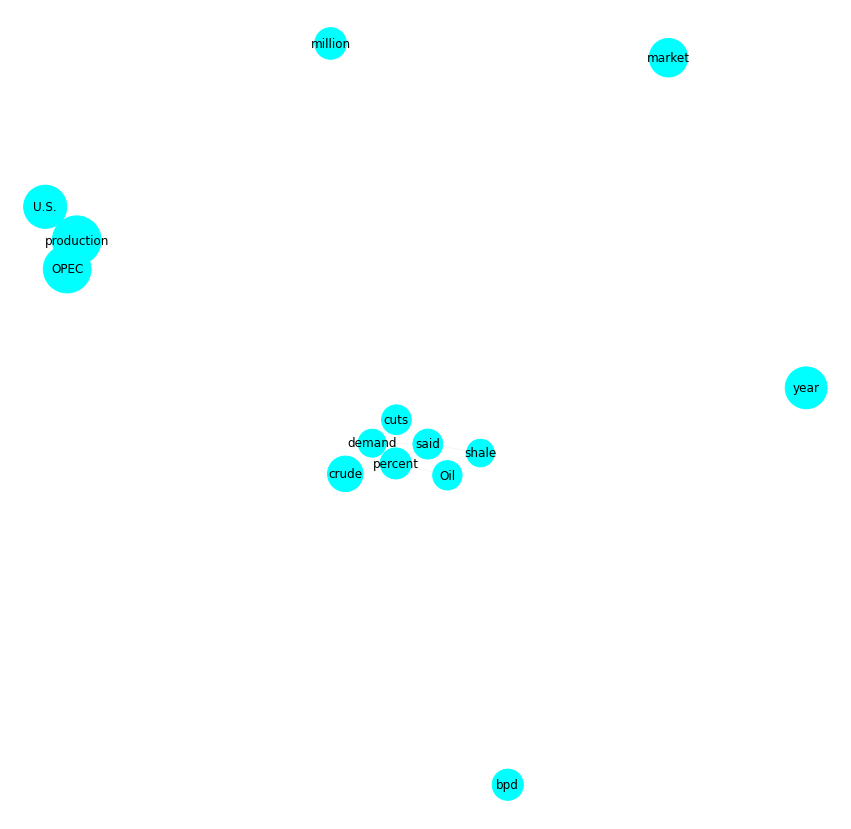

In [46]:
G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, k=0.1)

node_size = [d['count']*10 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color='cyan', alpha=1.0, node_size=node_size)
nx.draw_networkx_labels(G, pos)

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='grey', width=edge_width)

plt.axis('off')
plt.show()

In [45]:
G

In [ ]:
for ano in range(2010, 2022):
    corpus_oil_price["date_published"] = pd.to_datetime(corpus_oil_price["date_published"], utc=True)
    corpus_oil_price['year'] = corpus_oil_price['date_published'].dt.year
    filtered_df = corpus_oil_price.loc[corpus_oil_price['year']==ano]
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("[","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("]","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("'","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("',","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace(",'","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace(",","")
    col_one_list_2 = filtered_df['most_common_words'].tolist()
    col_one_list = []
    for i in col_one_list_2:
        listRes = list(i.split(" "))
        col_one_list.append(listRes)   

    stopwords = ["$","d","oil","prices","price","", " ", "barrel", "energy", "Friday", "Thursday", "July", "ndash", "Oil", "Crude", "weekrsquos", "Russiarsquos",
"3", "OPECrsquos", "1", "b", "non"]
    for c in col_one_list:
        #for i in range(len(c)):
        #    c[i] = c[i].lower()
        for word in c:  # iterating on a copy since removing will mess things up
            if word in stopwords:
                c.remove(word)
    
    stopwords = ["$","d","oil","prices","price","", " ", "barrel", "energy", "Friday", "Thursday", "July", "ndash", "Oil", "Crude", "weekrsquos", "Russiarsquos",
"3", "OPECrsquos", "1", "b", "non"]
    for c in col_one_list:
        #for i in range(len(c)):
        #    c[i] = c[i].lower()
        for word in c:  # iterating on a copy since removing will mess things up
            if word in stopwords:
                c.remove(word)
    
    stopwords = ["$","d","oil","prices","price","", " ", "barrel", "energy", "Friday", "Thursday", "July", "ndash", "Oil", "Crude", "weekrsquos", "Russiarsquos",
"3", "OPECrsquos", "1", "b", "non"]
    for c in col_one_list:
        #for i in range(len(c)):
        #    c[i] = c[i].lower()
        for word in c:  # iterating on a copy since removing will mess things up
            if word in stopwords:
                c.remove(word)
    
    word_cnt = {}
    for words in col_one_list:
        for w in words:
            if w not in word_cnt:
                word_cnt[w] = 1
            else:
                word_cnt[w] += 1
    
    word_cnt_df = pd.DataFrame({'word': [k for k in word_cnt.keys()], 'cnt': [v for v in word_cnt.values()]})
    word_cnt_df.sort_values(by=['cnt'])
    vocab = {}
    target_words = word_cnt_df[word_cnt_df['cnt'] > 5]['word'].to_numpy()
    for word in target_words:
        if word not in vocab:
            vocab[word] = len(vocab)

    re_vocab = {}
    for word, i in vocab.items():
        re_vocab[i] = word        
    
    combinations = [list(itertools.combinations(words, 2)) for words in col_one_list]
    combination_matrix = np.zeros((len(vocab), len(vocab)))

    for tweet_comb in combinations:
        for comb in tweet_comb:
            if comb[0] in target_words and comb[1] in target_words:
                combination_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
                combination_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
        
    for i in range(len(vocab)):
            combination_matrix[i, i] /= 2
        
    jaccard_matrix = 1 - distance.cdist(combination_matrix, combination_matrix, 'jaccard')
    nodes = []
    for i in range(len(vocab)):
        for j in range(i+1, len(vocab)):
            jaccard = jaccard_matrix[i, j]
            if jaccard > 0:
                nodes.append([re_vocab[i], re_vocab[j], word_cnt[re_vocab[i]], word_cnt[re_vocab[j]], jaccard])
    
    G = nx.Graph()
    G.nodes(data=True)
    for pair in nodes:
        node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
        if not G.has_node(node_x):
            G.add_node(node_x, count=node_x_cnt)
        if not G.has_node(node_y):
            G.add_node(node_y, count=node_y_cnt)
        if not G.has_edge(node_x, node_y):
            G.add_edge(node_x, node_y, weight=jaccard)
        
    plt.figure(figsize=(20,15))
    pos = nx.spring_layout(G, k=0.1)

    node_size = [d['count']*100 for (n,d) in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', alpha=1.0, node_size=node_size)
    nx.draw_networkx_labels(G, pos)

    edge_width = [d['weight']*7 for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='grey', width=edge_width)

    plt.axis('off')
    plt.savefig('images/oil'+str(ano)+'.png', dpi=300)


In [ ]:
for ano in range(2010, 2022):
    corpus_alternative_energies["date_published"] = pd.to_datetime(corpus_alternative_energies["date_published"], utc=True)
    corpus_alternative_energies['year'] = corpus_alternative_energies['date_published'].dt.year
    filtered_df = corpus_alternative_energies.loc[corpus_alternative_energies['year']==ano]
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("[","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("]","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("'","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace("',","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace(",'","")
    filtered_df['most_common_words'] = filtered_df['most_common_words'].str.replace(",","")
    col_one_list_2 = filtered_df['most_common_words'].tolist()
    col_one_list = []
    for i in col_one_list_2:
        listRes = list(i.split(" "))
        col_one_list.append(listRes)   

    stopwords = ["$","d","oil","prices","price","", " ", "energy", "power"]
    for c in col_one_list:
        #for i in range(len(c)):
        #    c[i] = c[i].lower()
        for word in c:  # iterating on a copy since removing will mess things up
            if word in stopwords:
                c.remove(word)
    
    stopwords = ["$","d","oil","prices","price","", " ", "energy", "power"]
    for c in col_one_list:
        #for i in range(len(c)):
        #    c[i] = c[i].lower()
        for word in c:  # iterating on a copy since removing will mess things up
            if word in stopwords:
                c.remove(word)
    
    stopwords = ["$","d","oil","prices","price","", " ", "energy", "power"]
    for c in col_one_list:
        #for i in range(len(c)):
        #    c[i] = c[i].lower()
        for word in c:  # iterating on a copy since removing will mess things up
            if word in stopwords:
                c.remove(word)
    
    word_cnt = {}
    for words in col_one_list:
        for w in words:
            if w not in word_cnt:
                word_cnt[w] = 1
            else:
                word_cnt[w] += 1
    
    word_cnt_df = pd.DataFrame({'word': [k for k in word_cnt.keys()], 'cnt': [v for v in word_cnt.values()]})
    word_cnt_df.sort_values(by=['cnt'])
    vocab = {}
    target_words = word_cnt_df[word_cnt_df['cnt'] > 5]['word'].to_numpy()
    for word in target_words:
        if word not in vocab:
            vocab[word] = len(vocab)

    re_vocab = {}
    for word, i in vocab.items():
        re_vocab[i] = word        
    
    combinations = [list(itertools.combinations(words, 2)) for words in col_one_list]
    combination_matrix = np.zeros((len(vocab), len(vocab)))

    for tweet_comb in combinations:
        for comb in tweet_comb:
            if comb[0] in target_words and comb[1] in target_words:
                combination_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
                combination_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
        
    for i in range(len(vocab)):
            combination_matrix[i, i] /= 2
        
    jaccard_matrix = 1 - distance.cdist(combination_matrix, combination_matrix, 'jaccard')
    nodes = []
    for i in range(len(vocab)):
        for j in range(i+1, len(vocab)):
            jaccard = jaccard_matrix[i, j]
            if jaccard > 0:
                nodes.append([re_vocab[i], re_vocab[j], word_cnt[re_vocab[i]], word_cnt[re_vocab[j]], jaccard])
    
    G = nx.Graph()
    G.nodes(data=True)
    for pair in nodes:
        node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
        if not G.has_node(node_x):
            G.add_node(node_x, count=node_x_cnt)
        if not G.has_node(node_y):
            G.add_node(node_y, count=node_y_cnt)
        if not G.has_edge(node_x, node_y):
            G.add_edge(node_x, node_y, weight=jaccard)
        
    plt.figure(figsize=(20,15))
    pos = nx.spring_layout(G, k=0.1)

    node_size = [d['count']*100 for (n,d) in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', alpha=1.0, node_size=node_size)
    nx.draw_networkx_labels(G, pos)

    edge_width = [d['weight']*7 for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='grey', width=edge_width)

    plt.axis('off')
    plt.savefig('images/energy'+str(ano)+'.png', dpi=300)
